# Generating dataset 
This notebook shows how to generate the train and test set for the multimnist and multimnist_cluttered tasks

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision import datasets
import copy
import os
from tqdm.notebook import tqdm
import numpy as np 
np.set_printoptions(suppress=True)

import random

# visualize affine augmentation


In [4]:
def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
dataset_type = 'test'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())



torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [51]:
# shifted version version

transforms = T.Compose([  T.RandomAffine(degrees=30, translate=(0.08, 0.08), scale=(0.7, 1.0), shear=30), T.ToTensor()])

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

    
images = []
# labels = []
for img, label in im_set:
    images.append(img)    
#     labels.append(label)
        
shift_images_tensorized = torch.stack([im for im in images])
print(shift_images_tensorized.size())

torch.Size([10000, 1, 28, 28])


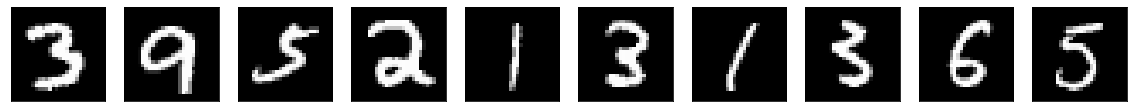

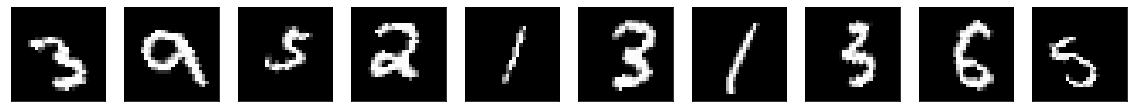

[tensor(3), tensor(9), tensor(5), tensor(2), tensor(1), tensor(3), tensor(1), tensor(3), tensor(6), tensor(5)]


In [55]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =50#152
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(shift_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

# Create mini-mnist C dataset for mini testing
get 1000 samples from each corruption dataset * 15 corruptions = 15000 sample images and labels

In [2]:
random.seed(10)
randomlist = random.sample(range(0, 10000), 1000)
# randomlist = [i for i in range(1000)]
# print(randomlist)
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']

path_root = '../data/MNIST_C'
# clist = os.listdir(path_root)
ilist = []
llist = []
for corruption in CORRUPTION_TYPES:
    path_images = os.path.join(path_root, corruption, 'test_images.npy')
    path_labels = os.path.join(path_root, corruption, 'test_labels.npy')
    images = np.load(path_images)
    labels = np.load(path_labels)
    
    ilist.append(images[randomlist])
    llist.append(labels[randomlist])

selected_images = np.vstack(ilist)
selected_labels = np.hstack(llist)
print(selected_images.shape) #(16000, 28, 28, 1)
print(selected_labels.shape) #(16000,)

(16000, 28, 28, 1)
(16000,)


In [3]:
#tranform to tensorized images (int8->float32,0-1) & one-hot vector for labels
transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
selected_images_tensorized = torch.stack([T.ToTensor()(im) for im in selected_images])
selected_labels_tensorized = torch.stack([transform_tohot(label) for label in selected_labels])
print(selected_images_tensorized.shape) #torch.Size([16000, 1, 28, 28])
print(selected_labels_tensorized.shape) #torch.Size([16000, 10])

torch.Size([16000, 1, 28, 28])
torch.Size([16000, 10])


In [4]:
# save tensorized dataset
path_save = os.path.join(path_root, 'mnistc_mini.pt')
torch.save((selected_images_tensorized, selected_labels_tensorized), path_save)
print('dataset saved to disk')

dataset saved to disk


In [31]:
##################################
# shuffle the order original mnistc (for visualization)
############################
# # print(randomlist)
# CORRUPTION_TYPES = ['identity', 
#          'shot_noise', 'impulse_noise','glass_blur','motion_blur',
#          'shear', 'scale',  'rotate',  'brightness',  'translate',
#          'stripe', 'fog','spatter','dotted_line', 'zigzag',
#          'canny_edges']
# CORRUPTION_TYPES = ['impulse_noise']

# path_root = '../data/MNIST_C'
# # clist = os.listdir(path_root)
# for corruption in CORRUPTION_TYPES:
#     randomlist = random.sample(range(0, 10000), 10000)

#     path_images = os.path.join(path_root, corruption, 'test_images.npy')
#     path_labels = os.path.join(path_root, corruption, 'test_labels.npy')
#     path_images_shuffled = os.path.join(path_root, corruption, 'test_images_shuffled.npy')
#     path_labels_shuffled = os.path.join(path_root, corruption, 'test_labels_shuffled.npy')
    
#     images = np.load(path_images)[randomlist]
#     labels = np.load(path_labels)[randomlist]
    
#     np.save(path_images_shuffled, images)
#     np.save(path_labels_shuffled, labels)

# print('shuffled images and labels are saved')

shuffled images and labels are saved


# Mnist with shape perception
- occlusion
- top-flipped
- scrambled

In [82]:
def generate_partition(img):
    h, w = 28, 28
    n_split=2

    try:
        h%n_split==0 & w%n_split==0
    except:
        print("That's not an integer number.")

    # Define the window size
    windowsize_r = int(h/n_split)
    windowsize_c = int(w/n_split)


    # Crop out the window and append to patches
    patches = []
    halves = []
    for r in range(0, h - windowsize_r+1, windowsize_r):
        half = img[r:r+windowsize_r,:]
        halves.append(half)
        for c in range(0, w - windowsize_c+1, windowsize_c):
            window = img[r:r+windowsize_r,c:c+windowsize_c]
            patches.append(window)


    # get array and randomly switch positions        
    patches_array = np.array(patches)
    rand_idx = random.sample(range(0,n_split*n_split), n_split*n_split)
    patches_random = patches_array[rand_idx]


    # get top-flipped array
    halves_array = np.array(halves)
    halves_array[0] = np.fliplr(halves_array[0])
    final_topflipped = np.vstack(halves_array)

    # combine patch images to original shape + images with original order but one patch erased
    occlusion_idx = random.sample(range(0,n_split*n_split), 1)[0]
    final_occlusion =  np.zeros_like(img)
    final_random = np.zeros_like(img)

    index = 0
    for r in range(0, w - windowsize_r+1, windowsize_r):
        for c in range(0, h - windowsize_c+1, windowsize_c):
            final_random[r:r+windowsize_r,c:c+windowsize_c] = patches_random[index]
            if index == occlusion_idx:
                final_occlusion[r:r+windowsize_r,c:c+windowsize_c] = np.zeros_like(patches_random[index])
            else:
                final_occlusion[r:r+windowsize_r,c:c+windowsize_c] = patches_array[index]
            index += 1

    #visualize
#     fig = plt.figure(figsize=(15, 80))
#     fig.add_subplot(1, 4, 1)      
#     plt.imshow(img, cmap='gray')
#     fig.add_subplot(1, 4, 2)      
#     plt.imshow(final_occlusion, cmap='gray')
#     fig.add_subplot(1, 4, 3)      
#     plt.imshow(final_topflipped, cmap='gray')
#     fig.add_subplot(1, 4, 4)      
#     plt.imshow(final_random, cmap='gray')

    return final_occlusion, final_topflipped, final_random

def get_tensorized_dataset(im_set):
    images = []
    occlusions = []
    topflipped=[]
    randoms= []

    labels = []
    for img, label in im_set:
        img = np.array(img)
        occlusion, top, random = generate_partition(img)
        images.append(img)
        occlusions.append(occlusion)
        topflipped.append(top)
        randoms.append(random)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    occlusions_tensorized = torch.stack([T.ToTensor()(im) for im in occlusions])
    topflipped_tensorized = torch.stack([T.ToTensor()(im) for im in topflipped])
    randoms_tensorized = torch.stack([T.ToTensor()(im) for im in randoms])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, occlusions_tensorized, topflipped_tensorized, randoms_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_shape'
dataset_type = 'test'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, occlusion_images_tensorized, topflipped_images_tensorized, random_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(occlusion_images_tensorized.size())
print(topflipped_images_tensorized.size())
print(random_images_tensorized.size())

print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


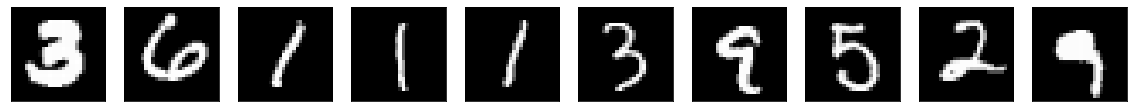

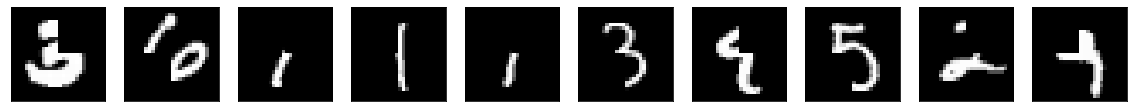

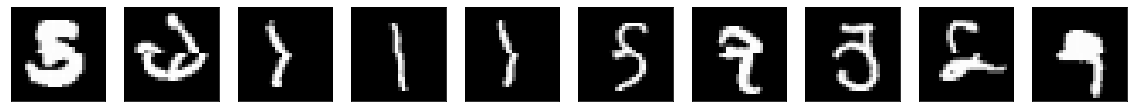

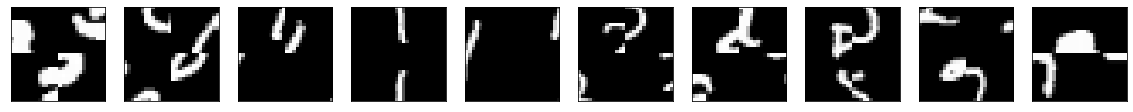

[tensor(3), tensor(6), tensor(1), tensor(1), tensor(1), tensor(3), tensor(9), tensor(5), tensor(2), tensor(9)]


In [87]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =20#152

plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(occlusion_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(topflipped_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(random_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [88]:
# save tensors 
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_occlusion.pt')
torch.save((occlusion_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_flipped.pt')
torch.save((topflipped_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

filename = os.path.join(path_save, f'{dataset_type}_random.pt')
torch.save((random_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')


../data/MNIST_shape/test_occlusion.pt saved to disk
../data/MNIST_shape/test_flipped.pt saved to disk
../data/MNIST_shape/test_random.pt saved to disk


# Mnist with pixel shift (translation only)
- we allowed upto 2 pixels shifts with zeropadding as done in original capsnet paper, Sabour 2017)

In [14]:
def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_shift'
dataset_type = 'train'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


In [15]:
# shifted version version
max_portion = [0.08, 0.08] # this corresponds to upto 2 pixel changes of 28x28 image when round up; sourcecode: https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomAffine.html#torchvision.transforms.RandomAffine

transforms = T.Compose([ T.RandomAffine(degrees=0, translate=max_portion), T.ToTensor()])

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

    
images = []
# labels = []
for img, label in im_set:
    images.append(img)    
#     labels.append(label)
        
shift_images_tensorized = torch.stack([im for im in images])
print(shift_images_tensorized.size())

torch.Size([60000, 1, 28, 28])


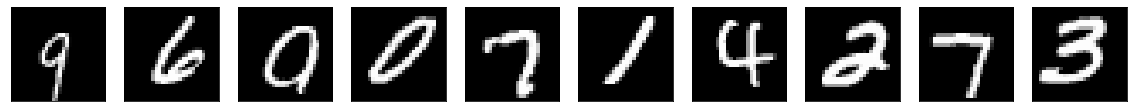

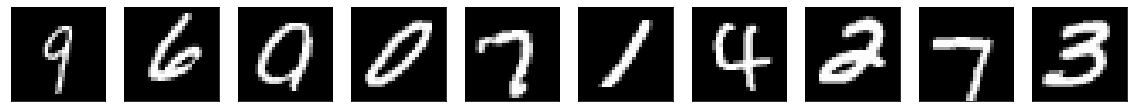

[tensor(9), tensor(6), tensor(9), tensor(0), tensor(7), tensor(1), tensor(4), tensor(2), tensor(7), tensor(3)]


In [16]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(shift_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [17]:
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_shift_by_2pixel.pt')
torch.save((shift_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')


../data/MNIST_shift/train_shift_by_2pixel.pt saved to disk


# Mnist data for reconstruction (BLUR)
In this task, the model has to reconstruct blur version, given original clear mnist
- original mnist training dataset: 60k, 10k for testing

In [53]:
def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray_r', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'test'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [3]:
# blurred version
kernelsize = 5
sigma =5.0
transforms = T.Compose([ T.GaussianBlur(kernelsize, sigma=sigma), T.ToTensor()])

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

    
images = []
# labels = []
for img, label in im_set:
    images.append(img)    
#     labels.append(label)
        
blur_images_tensorized = torch.stack([im for im in images])
# blur_labels_tensorized = torch.stack([label for label in labels])
print(blur_images_tensorized.size())

bool_images_tensorized = (blur_images_tensorized >0.1).type(torch.float32)
# blur_labels_tensorized = torch.stack([label for label in labels])
print(bool_images_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])


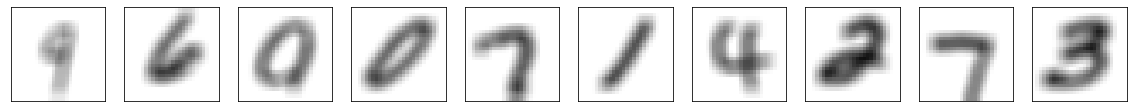

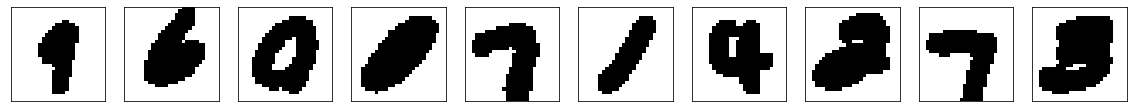

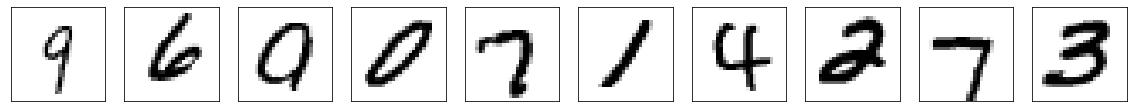

[tensor(9), tensor(6), tensor(9), tensor(0), tensor(7), tensor(1), tensor(4), tensor(2), tensor(7), tensor(3)]


In [4]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(blur_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(bool_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [5]:
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_blur_k{kernelsize}s{int(sigma)}.pt')
torch.save((orig_images_tensorized, blur_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

filename = os.path.join(path_save, f'{dataset_type}_blur_k{kernelsize}s{int(sigma)}_bool.pt')
torch.save((orig_images_tensorized, bool_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_blur_k5s5.pt saved to disk
../data/MNIST_recon/train_blur_k5s5_bool.pt saved to disk


# Mnist data for reconstruction (contour)
In this task, the model has to reconstruct contour version, given original clear mnist
- original mnist training dataset: 60k, 10k for testing

In [38]:
from skimage import transform, feature
def canny_edges(x):
    x = np.array(x) / 255.
    x = feature.canny(x)
    return (x * 255).astype(np.uint8)

def get_tensorized_dataset(im_set):
    images = []
    edges=[]
    labels = []
    for img, label in im_set:
#         import pdb; pdb.set_trace()
        img = np.array(img)
        images.append(img)    
        e = canny_edges(img)
        edges.append(e)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    edges_tensorized = torch.stack([T.ToTensor()(im) for im in edges])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, edges_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'train'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, edge_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(edge_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


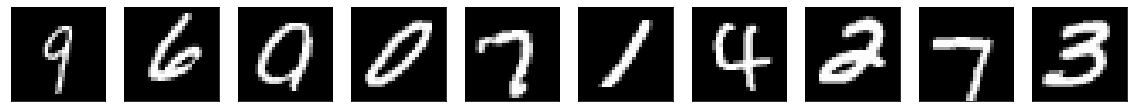

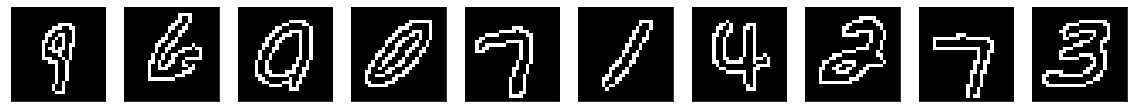

[tensor(9), tensor(6), tensor(9), tensor(0), tensor(7), tensor(1), tensor(4), tensor(2), tensor(7), tensor(3)]


In [20]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

plottedimgs = [torch.movedim(edge_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [21]:
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_canny_edge.pt')
torch.save((orig_images_tensorized, edge_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_canny_edge.pt saved to disk


## make the half & half dataset between intact and erased images

In [39]:
# get half indicies from each dataset
labels_tensorized= orig_labels_tensorized
intact_images_tensorized = orig_images_tensorized
random.seed(10)
n_images = len(labels_tensorized)
all_indices = list(range(0, n_images))
edge_indices = random.sample(range(0, n_images), int(n_images/2))
edge_indices.sort()
intact_indices = list(set(all_indices)-set(edge_indices))
print(f'among {n_images} intact images, {int(n_images/2)} were replaced with edge version')
    
half_intact_images = intact_images_tensorized[intact_indices]
half_edge_images = edge_images_tensorized[edge_indices]
half_intact_labels = labels_tensorized[intact_indices]
half_edge_labels = labels_tensorized[edge_indices]
intact_images_for_half_edge = intact_images_tensorized[edge_indices]
half_intact_half_edge_images = torch.cat([half_intact_images, half_edge_images])
all_intact_images = torch.cat([half_intact_images, intact_images_for_half_edge])
half_intact_half_edge_labels  = torch.cat([half_intact_labels, half_edge_labels])

# shuffle the order
torch.manual_seed(10)
shuffled_indices = torch.randperm(half_intact_half_edge_images.shape[0])
half_intact_half_edge_images = half_intact_half_edge_images[shuffled_indices]
all_intact_images = all_intact_images[shuffled_indices]
half_intact_half_edge_labels = half_intact_half_edge_labels[shuffled_indices]

print(half_intact_half_edge_images.size())
print(all_intact_images.size())
print(half_intact_half_edge_labels.size())

among 60000 intact images, 30000 were replaced with edge version
torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


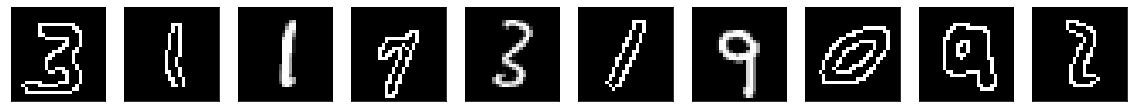

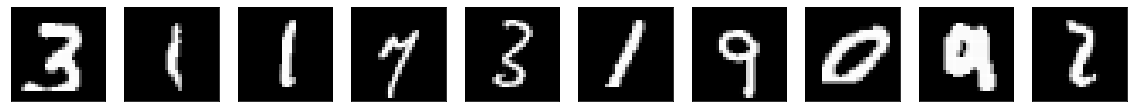

[tensor(3), tensor(1), tensor(1), tensor(7), tensor(3), tensor(1), tensor(9), tensor(0), tensor(9), tensor(2)]


In [40]:
# visualize edge images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
i=4
plottedimgs = [torch.movedim(half_intact_half_edge_images[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(all_intact_images[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in half_intact_half_edge_labels[10*i:10*(i+1)]])

In [41]:
# tensor save recon-half
filename = os.path.join(path_save, f'{dataset_type}_half_orig_half_edge.pt')
torch.save((half_intact_half_edge_images, all_intact_images, half_intact_half_edge_labels), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_half_orig_half_edge.pt saved to disk


# Other MNISTs experimented

## mnist with blot background

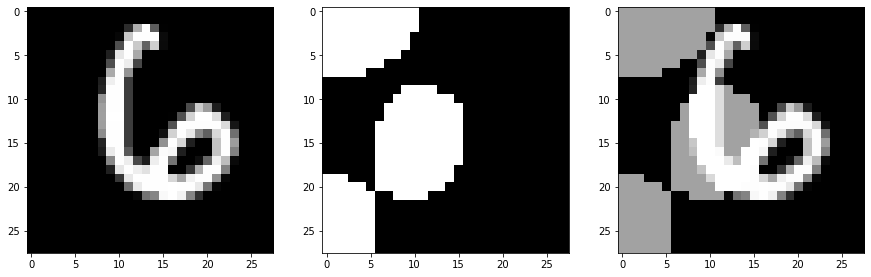

In [205]:
# partly erased stimuli demonstration
from scipy import ndimage
import random
# np.random.seed(1)
fig = plt.figure(figsize=(15, 80))
im_set = datasets.MNIST('../data/',train=False, download=False)

# image
i = 88
im = np.array(im_set[i][0])
fig.add_subplot(1, 3, 1)
plt.imshow(im, cmap='gray')


## blots
nblots = 5
sigma = 3
blots = np.zeros(im.shape)
points = im.shape[0]*np.random.random((2, nblots))
blots[(points[0]).astype(np.int64), (points[1]).astype(np.int64)] = 1
blots = ndimage.gaussian_filter(blots, sigma=sigma)
blotmask = (blots > blots.mean()).astype(np.int64)
blotbg = np.random.randint(0,255)*blotmask

# blotted
bim = im.copy().astype(np.int64)
imwbg =np.clip(bim+blotbg, a_max=255, a_min=0)
imwbg = imwbg.astype(np.uint8)

blotbg = blotbg.astype(np.uint8)
fig.add_subplot(1, 3, 2)
plt.imshow(blotbg, cmap='gray')


fig.add_subplot(1, 3, 3)
plt.imshow(imwbg, cmap='gray')
plt.show()

In [211]:
def get_blot_dataset(im_set, nblots=5):
    intact_images = []
    blotted_images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        intact_images.append(img)    
        blotted = blot_image(img.copy(), nblots)
        blotted_images.append(blotted)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    intact_images_tensorized = torch.stack([T.ToTensor()(im) for im in intact_images])
    blotted_images_tensorized = torch.stack([T.ToTensor()(im) for im in blotted_images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return intact_images_tensorized, blotted_images_tensorized, labels_tensorized

def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def blot_image(img, nblots=5, sigma=3, maskvalue=0):
    from scipy import ndimage
    # create blots
    img =img.astype(np.int64)
    blots = np.zeros(img.shape)
    points = img.shape[0]*np.random.random((2, nblots))
    blots[(points[0]).astype(np.int64), (points[1]).astype(np.int64)] = 1
    blots = ndimage.gaussian_filter(blots, sigma=sigma)
    blotmask = (blots > blots.mean()).astype(np.int64)
    blotbg = np.random.randint(0,255)*blotmask

    # put blot to original image 
    new_img =np.clip(img+blotbg, a_max=255, a_min=0)
    return new_img.astype(np.uint8)

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

In [222]:
# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'test'
if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [223]:
# convert original mnist to random blot
random.seed(10)
increase_datasize_by=1

intact_images, blotted_images, labels = [], [], []
for i in range(increase_datasize_by):
    intact, blotted, lab = get_blot_dataset(im_set, nblots=5)
    intact_images.append(intact)
    blotted_images.append(blotted)
    labels.append(lab)
    
intact_images_tensorized = torch.cat(intact_images)
blotted_images_tensorized = torch.cat(blotted_images)
labels_tensorized = torch.cat(labels)

print(intact_images_tensorized.size())
print(blotted_images_tensorized.size())
print(labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


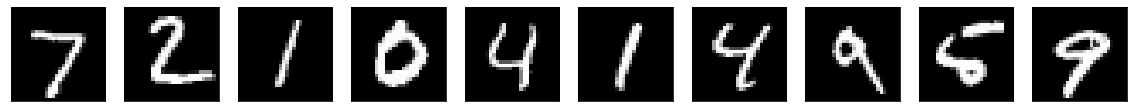

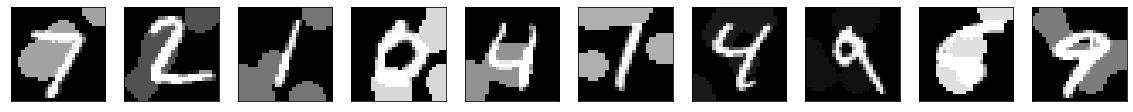

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9)]


In [224]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(intact_images_tensorized[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(blotted_images_tensorized[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in labels_tensorized[:10]])

In [225]:
# save tensors recon-all
comment = 'blot5bg'
filename = os.path.join(path_save, f'{dataset_type}_recon_only_x{increase_datasize_by}_{comment}.pt')
torch.save((blotted_images_tensorized, intact_images_tensorized, labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/test_recon_only_x1_blot5bg.pt saved to disk


In [226]:
#concate intact + erased
combine_intact_blotted_images = torch.cat([orig_images_tensorized, blotted_images_tensorized]) # torch.Size([120000, 28, 28])
combine_intact_images = torch.cat([orig_images_tensorized, intact_images_tensorized])
combine_labels_tensorized = torch.cat([orig_labels_tensorized, labels_tensorized]) #

# shuffle the order
torch.manual_seed(10)
shuffled_indices = torch.randperm(combine_intact_blotted_images.shape[0])
combine_intact_blotted_images = combine_intact_blotted_images[shuffled_indices]
combine_intact_images = combine_intact_images[shuffled_indices]
combine_labels_tensorized = combine_labels_tensorized[shuffled_indices]

print(combine_intact_blotted_images .size())
print(combine_intact_images.size())
print(combine_labels_tensorized.size())

torch.Size([20000, 1, 28, 28])
torch.Size([20000, 1, 28, 28])
torch.Size([20000, 10])


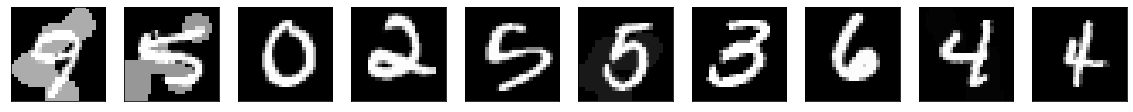

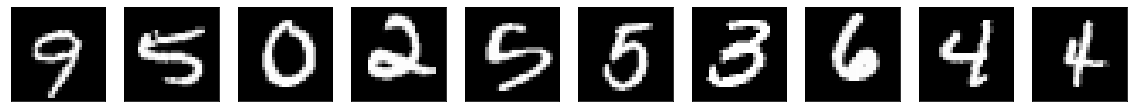

[tensor(0), tensor(8), tensor(0), tensor(1), tensor(7), tensor(7), tensor(0), tensor(1), tensor(8), tensor(0)]


In [227]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(combine_intact_blotted_images[i], 0 ,-1) for i in range(10,20)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(combine_intact_images[i], 0 ,-1) for i in range(10,20)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in combine_labels_tensorized[:10]])

In [228]:
# tensor save recon-half
comment = 'blot5bg'
filename = os.path.join(path_save, f'{dataset_type}_recon_combine_x{increase_datasize_by}_{comment}.pt')
torch.save((combine_intact_blotted_images, combine_intact_images, combine_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/test_recon_combine_x1_blot5bg.pt saved to disk


# mnist for reconstruction (erased version)
original mnist training dataset: 60k
* recon-only (x*60k erased)
* recon-balance (x*30k intact + x*30k erased)
* recon-unbalanced (original 60k intact + x*60k erased)

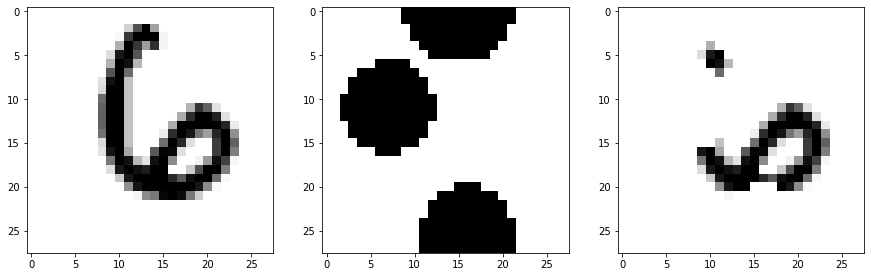

In [7]:
# partly erased stimuli demonstration
from scipy import ndimage
# np.random.seed(1)
fig = plt.figure(figsize=(15, 80))

im_set = datasets.MNIST('../data/',train=False, download=False)

# image
i = 88
im = np.array(im_set[i][0])
fig.add_subplot(1, 3, 1)
plt.imshow(im, cmap='gray_r')

## blots
nblots = 3
sigma = 3
blots = np.zeros(im.shape)
points = im.shape[0]*np.random.random((2, nblots))
blots[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
blots = ndimage.gaussian_filter(blots, sigma=sigma)
blotmask = (blots > blots.mean()).astype(np.int)
fig.add_subplot(1, 3, 2)
plt.imshow(blotmask, cmap='gray_r')

# blotted
# bim = im.copy()
maskvalue = 0
np.putmask(im, blotmask, maskvalue)
fig.add_subplot(1, 3, 3)
plt.imshow(im, cmap='gray_r')
plt.show()

In [53]:
def get_randomly_erased_dataset(im_set, nblots=3):
    intact_images = []
    erased_images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        intact_images.append(img)    
        erased = erase_image(img.copy(), nblots)
        erased_images.append(erased)
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    intact_images_tensorized = torch.stack([T.ToTensor()(im) for im in intact_images])
    erased_images_tensorized = torch.stack([T.ToTensor()(im) for im in erased_images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return intact_images_tensorized, erased_images_tensorized, labels_tensorized

def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def erase_image(img, nblots=3, sigma=3, maskvalue=0):
    from scipy import ndimage
    # create blots
    blots = np.zeros(img.shape)
    points = img.shape[0]*np.random.random((2, nblots))
    blots[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    blots = ndimage.gaussian_filter(blots, sigma=sigma)
    blotmask = (blots > blots.mean()).astype(np.int)
    
    # put blotmask on original image 
    np.putmask(img, blotmask, maskvalue) # check how this works for 3D, RGB array
    
    return img

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray_r', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

In [51]:
# load original mnist
path_save = '../data/MNIST_recon'
dataset_type = 'train'
if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


# create erased mnist

In [54]:
# convert original mnist to randomly erased mnist
random.seed(10)
increase_datasize_by=3

intact_images, erased_images, labels = [], [], []
for i in range(increase_datasize_by):
    intact, erased, lab = get_randomly_erased_dataset(im_set, nblots=2*i+1)
    intact_images.append(intact)
    erased_images.append(erased)
    labels.append(lab)
    
intact_images_tensorized = torch.cat(intact_images)
erased_images_tensorized = torch.cat(erased_images)
labels_tensorized = torch.cat(labels)

print(intact_images_tensorized.size())
print(erased_images_tensorized.size())
print(labels_tensorized.size())

torch.Size([180000, 1, 28, 28])
torch.Size([180000, 1, 28, 28])
torch.Size([180000, 10])


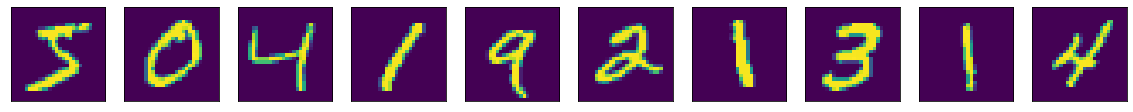

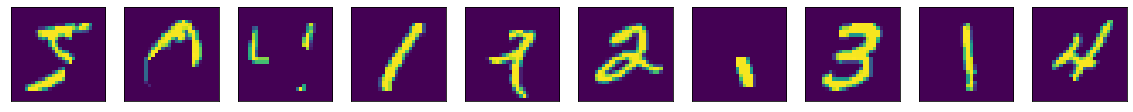

[tensor(5), tensor(0), tensor(4), tensor(1), tensor(9), tensor(2), tensor(1), tensor(3), tensor(1), tensor(4)]


In [55]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(intact_images_tensorized[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(erased_images_tensorized[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in labels_tensorized[:10]])

In [56]:
# save tensors recon-all
comment = '_nblot1to3'
filename = os.path.join(path_save, f'{dataset_type}_recon_only_x{increase_datasize_by}{comment}.pt')
torch.save((erased_images_tensorized, intact_images_tensorized, labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_recon_only_x3_nblot1to3.pt saved to disk


## make the half & half dataset between intact and erased images

In [57]:
# get half indicies from each dataset
random.seed(10)
n_images = len(labels_tensorized)
all_indices = list(range(0, n_images))
erased_indices = random.sample(range(0, n_images), int(n_images/2))
erased_indices.sort()
intact_indices = list(set(all_indices)-set(erased_indices))
print(f'among {n_images} intact images, {int(n_images/2)} were replaced with erased version')
    
half_intact_images = intact_images_tensorized[intact_indices]
half_erased_images = erased_images_tensorized[erased_indices]
half_intact_labels = labels_tensorized[intact_indices]
half_erased_labels = labels_tensorized[erased_indices]
intact_images_for_half_erased = intact_images_tensorized[erased_indices]
half_intact_half_erased_images = torch.cat([half_intact_images, half_erased_images])
all_intact_images = torch.cat([half_intact_images, intact_images_for_half_erased])
half_intact_half_erased_labels  = torch.cat([half_intact_labels, half_erased_labels])

# shuffle the order
torch.manual_seed(10)
shuffled_indices = torch.randperm(half_intact_half_erased_images.shape[0])
half_intact_half_erased_images = half_intact_half_erased_images[shuffled_indices]
all_intact_images = all_intact_images[shuffled_indices]
half_intact_half_erased_labels = half_intact_half_erased_labels[shuffled_indices]

print(half_intact_half_erased_images.size())
print(all_intact_images.size())
print(half_intact_half_erased_labels.size())

among 180000 intact images, 90000 were replaced with erased version
torch.Size([180000, 1, 28, 28])
torch.Size([180000, 1, 28, 28])
torch.Size([180000, 10])


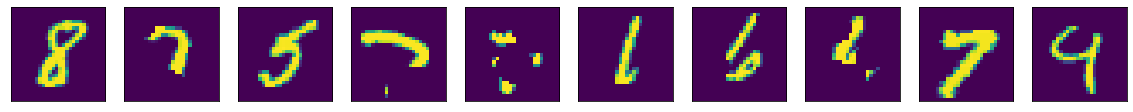

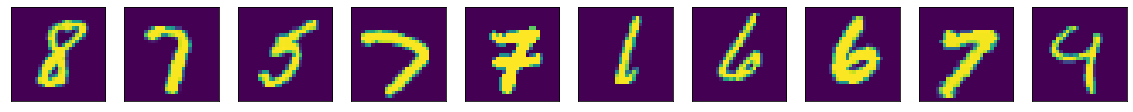

[tensor(8), tensor(7), tensor(5), tensor(7), tensor(7), tensor(1), tensor(6), tensor(6), tensor(7), tensor(9)]


In [58]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(half_intact_half_erased_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(all_intact_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in half_intact_half_erased_labels[:10]])

In [59]:
# tensor save recon-half
comment = '_nblot1to3'
filename = os.path.join(path_save, f'{dataset_type}_recon_half_x{increase_datasize_by}{comment}.pt')
torch.save((half_intact_half_erased_images, all_intact_images, half_intact_half_erased_labels), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_recon_half_x3_nblot1to3.pt saved to disk


# concat erased images to original mnist 

In [60]:
#concate intact + erased
combine_intact_erased_images = torch.cat([orig_images_tensorized, erased_images_tensorized]) # torch.Size([120000, 28, 28])
combine_intact_images = torch.cat([orig_images_tensorized, intact_images_tensorized])
combine_labels_tensorized = torch.cat([orig_labels_tensorized, labels_tensorized]) #

# shuffle the order
torch.manual_seed(10)
shuffled_indices = torch.randperm(combine_intact_erased_images.shape[0])
combine_intact_erased_images = combine_intact_erased_images[shuffled_indices]
combine_intact_images = combine_intact_images[shuffled_indices]
combine_labels_tensorized = combine_labels_tensorized[shuffled_indices]

print(combine_intact_erased_images .size())
print(combine_intact_images.size())
print(combine_labels_tensorized.size())

torch.Size([240000, 1, 28, 28])
torch.Size([240000, 1, 28, 28])
torch.Size([240000, 10])


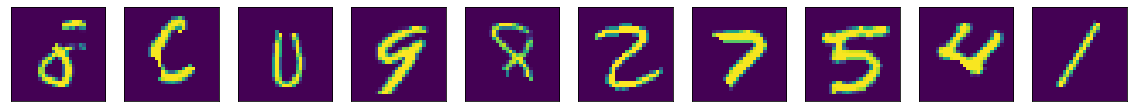

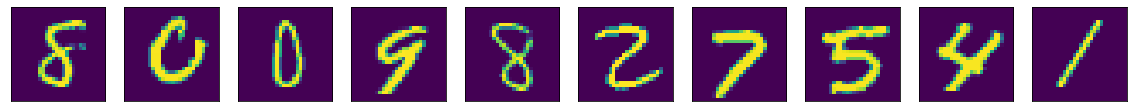

[tensor(8), tensor(0), tensor(0), tensor(9), tensor(8), tensor(2), tensor(7), tensor(5), tensor(4), tensor(1)]


In [61]:
# visualize erased images
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plottedimgs = [torch.movedim(combine_intact_erased_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(combine_intact_images[i], 0 ,-1) for i in range(10)]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in combine_labels_tensorized[:10]])

In [62]:
# tensor save recon-half
comment = '_nblot1to3'
filename = os.path.join(path_save, f'{dataset_type}_recon_combine_x{increase_datasize_by}{comment}.pt')
torch.save((combine_intact_erased_images, combine_intact_images, combine_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_recon/train_recon_combine_x3_nblot1to3.pt saved to disk


# mnist with image background
download dataset from here: https://sites.google.com/a/lisa.iro.umontreal.ca/public_static_twiki/variations-on-the-mnist-digits


In [93]:
# get original dataset
path_data = '../data/MNIST_bgimage/'
dataset_type = 'test'

def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [94]:
def get_tensorized_dataset(im_set):
    
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        img = img.reshape([28,28]).T
        images.append(img)
        labels.append(int(label[0]))
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()


# load data and tensorize


data = np.loadtxt(path_data+f'mnist_background_images_{dataset_type}.amat')
add_im_set = zip(data[:, :-1], data[:, -1:])

add_images_tensorized, add_labels_tensorized = get_tensorized_dataset(add_im_set)
add_images_tensorized = add_images_tensorized.type(torch.float32)
add_labels_tensorized = add_labels_tensorized.type(torch.float32)

print(add_images_tensorized.size())
print(add_labels_tensorized.size())

# torch.Size([12000, 1, 28, 28])
# torch.Size([12000, 10])

torch.Size([50000, 1, 28, 28])
torch.Size([50000, 10])


In [95]:
# concat
concat_images = torch.cat([orig_images_tensorized, add_images_tensorized], dim=0)
concat_labels = torch.cat([orig_labels_tensorized, add_labels_tensorized], dim=0)

# shuffle
shuffled_ids= torch.randperm(concat_images.shape[0])
concat_images = concat_images[shuffled_ids]
concat_labels = concat_labels[shuffled_ids]

print(concat_images.size())
print(concat_labels.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


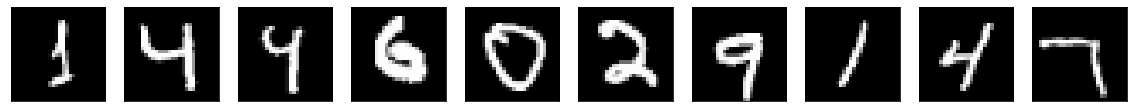

[tensor(1), tensor(4), tensor(4), tensor(6), tensor(0), tensor(2), tensor(9), tensor(1), tensor(4), tensor(7)]


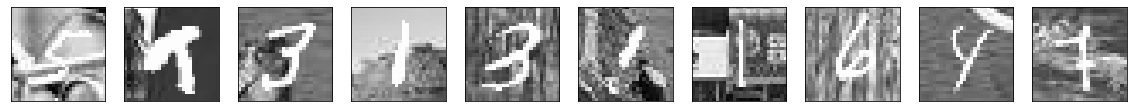

[tensor(5), tensor(9), tensor(3), tensor(1), tensor(3), tensor(1), tensor(1), tensor(6), tensor(4), tensor(7)]


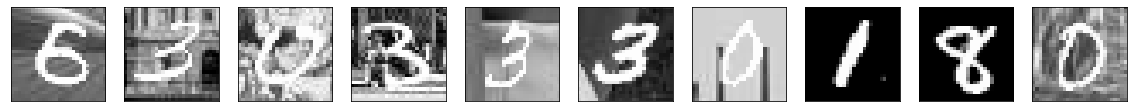

[tensor(6), tensor(3), tensor(0), tensor(3), tensor(3), tensor(3), tensor(0), tensor(1), tensor(8), tensor(0)]


In [96]:
# visualize
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

plottedimgs = [torch.movedim(add_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in add_labels_tensorized[10*i:10*(i+1)]])

plottedimgs = [torch.movedim(concat_images[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in concat_labels[10*i:10*(i+1)]])

In [74]:
# save additional tensors 
filename = os.path.join(path_data, f'{dataset_type}_bgimage.pt')
torch.save((add_images_tensorized, add_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_bgimage/train_bgimage.pt saved to disk


In [97]:
## add to original + additional concat dataset
filename = os.path.join(path_data, f'{dataset_type}_original_and_bgimage.pt')
torch.save((concat_images, concat_labels), filename)
print(f'{filename} saved to disk')

../data/MNIST_bgimage/test_original_and_bgimage.pt saved to disk


# mnist with random background
download dataset from here: https://sites.google.com/a/lisa.iro.umontreal.ca/public_static_twiki/variations-on-the-mnist-digits


In [103]:
# get original dataset
path_data = '../data/MNIST_bgrandom/'
dataset_type = 'test'

def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [104]:
def get_tensorized_dataset(im_set):
    
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        img = img.reshape([28,28]).T
        images.append(img)
        labels.append(int(label[0]))
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()


# load data and tensorize


data = np.loadtxt(path_data+f'mnist_background_random_{dataset_type}.amat')
add_im_set = zip(data[:, :-1], data[:, -1:])

add_images_tensorized, add_labels_tensorized = get_tensorized_dataset(add_im_set)
add_images_tensorized = add_images_tensorized.type(torch.float32)
add_labels_tensorized = add_labels_tensorized.type(torch.float32)

print(add_images_tensorized.size())
print(add_labels_tensorized.size())

# torch.Size([12000, 1, 28, 28])
# torch.Size([12000, 10])

torch.Size([50000, 1, 28, 28])
torch.Size([50000, 10])


In [105]:
# concat
concat_images = torch.cat([orig_images_tensorized, add_images_tensorized], dim=0)
concat_labels = torch.cat([orig_labels_tensorized, add_labels_tensorized], dim=0)

# shuffle
shuffled_ids= torch.randperm(concat_images.shape[0])
concat_images = concat_images[shuffled_ids]
concat_labels = concat_labels[shuffled_ids]

print(concat_images.size())
print(concat_labels.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


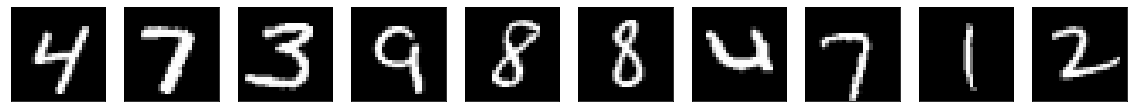

[tensor(4), tensor(7), tensor(3), tensor(9), tensor(8), tensor(8), tensor(4), tensor(7), tensor(1), tensor(2)]


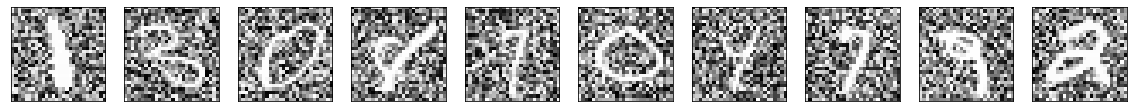

[tensor(1), tensor(3), tensor(0), tensor(8), tensor(7), tensor(0), tensor(4), tensor(7), tensor(9), tensor(2)]


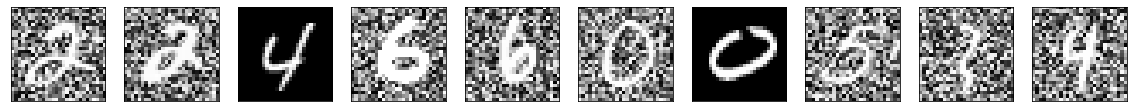

[tensor(2), tensor(2), tensor(4), tensor(6), tensor(6), tensor(0), tensor(0), tensor(5), tensor(3), tensor(4)]


In [110]:
# visualize
plt.rcParams["figure.figsize"] = (20,3)
i =91#152
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

plottedimgs = [torch.movedim(add_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in add_labels_tensorized[10*i:10*(i+1)]])

plottedimgs = [torch.movedim(concat_images[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in concat_labels[10*i:10*(i+1)]])

In [74]:
# save additional tensors 
filename = os.path.join(path_data, f'{dataset_type}_bgrandom.pt')
torch.save((add_images_tensorized, add_labels_tensorized), filename)
print(f'{filename} saved to disk')

../data/MNIST_bgimage/train_bgimage.pt saved to disk


In [107]:
## add to original + additional concat dataset
filename = os.path.join(path_data, f'{dataset_type}_original_and_bgrandom.pt')
torch.save((concat_images, concat_labels), filename)
print(f'{filename} saved to disk')

../data/MNIST_bgrandom/test_original_and_bgimage.pt saved to disk
